In [1]:
%matplotlib widget
import os
import h5py
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5

In [3]:
searchfor = '.h5'
searchdir = '../IceLakesRun2/detection_out_data/'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f)]
print(len(filelist))

25094


In [78]:
thresh_upper = 1.005
thresh_lower = -5.505

bin_h = 0.01
smooth_h_top = 0.05
smooth_h_middle = 0.1
smooth_h_bottom = 0.2
switch1 = -1.2
switch2 = -2.1
bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
mids = bins[:-1] + 0.5 * bin_h
smooth_top = int(np.round(smooth_h_top/bin_h))
smooth_middle = int(np.round(smooth_h_middle/bin_h))
smooth_bottom = int(np.round(smooth_h_bottom/bin_h))

beam_counts = np.zeros(6)
df_counts = pd.DataFrame({'elev_bins': mids})
for beam in np.arange(1,7):
    df_counts['counts_%i' % beam] = 0
                         

# for i,fn in enumerate(filelist[:1000]):
for i,fn in enumerate(filelist):
    print('reading file %5i / %5i' % (i+1, len(filelist)), end='\r')
    try:
        lk = read_melt_lake_h5(fn)
        df = lk['photon_data']
        dfs = df[(df.sat_ratio >= 1.0)].copy()
        beamnr = lk['beam_number']
        beam_counts[beamnr-1] += 1
        if len(dfs) > 0:
            dfs['h_relative_to_saturated_peak'] = dfs.h - dfs.sat_elev
            histweights = np.clip(np.array(dfs.sat_ratio).astype(np.float64) - 1.0, 0, 20)
            hist_h = np.histogram(np.array(dfs.h_relative_to_saturated_peak).astype(np.float64), bins=bins, weights=histweights)
            df_counts.iloc[:, beamnr] += hist_h[0]
    except:
        pass

df_counts['counts_all'] = np.sum(df_counts.iloc[:,1:7],axis=1)
df_counts['counts_strong'] = np.sum(df_counts.iloc[:,[1,3,5]],axis=1)
df_counts['counts_weak'] = np.sum(df_counts.iloc[:,[2,4,6]],axis=1)

df_counts.to_csv('data/saturation_countsonly_alldata.csv', index=False)

bn = beam_counts.astype(np.int64)
df_lake_counts = pd.DataFrame({'all': np.sum(bn), 'strong': np.sum(bn[[0,2,4]]), 'weak': np.sum(bn[[1,3,5]])}, index=[0])
for i in np.arange(1,7):
    df_lake_counts['beam_%i' % i] = bn[i-1]
df_lake_counts.to_csv('data/saturation_counts_alldata_lakecounts.csv', index=False)
df_lake_counts

,all,strong,weak,beam_1,beam_2,beam_3,beam_4,beam_5,beam_6
0,24961,12592,12369,3851,4035,4942,4465,3799,3869


In [87]:
smooth_h_top = 0.01
smooth_h_middle = 0.03
smooth_h_bottom = 0.08
switch1 = -1.1
switch2 = -2.0
smooth_top = int(np.round(smooth_h_top/bin_h))
smooth_middle = int(np.round(smooth_h_middle/bin_h))
smooth_bottom = int(np.round(smooth_h_bottom/bin_h))
for i, beam_select in enumerate(['all', 'strong', 'weak'] + list(np.arange(1,7))):
    hist_h = df_counts['counts_%s' % beam_select] 
    hist_h_smooth_top = np.array(pd.Series(hist_h).rolling(smooth_top,center=True,min_periods=1).mean())
    hist_h_smooth_middle = np.array(pd.Series(hist_h).rolling(smooth_middle,center=True,min_periods=1).mean())
    hist_h_smooth_bottom = np.array(pd.Series(hist_h).rolling(smooth_bottom,center=True,min_periods=1).mean())
    seg1 = hist_h_smooth_bottom[mids<=switch2]
    seg2 = hist_h_smooth_middle[(mids>switch2) & (mids<=switch1)]
    seg3 = hist_h_smooth_top[mids>switch1]
    hist_h_smooth = np.concatenate((seg1, seg2, seg3))
    hist_h_full = hist_h / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    if i == 0:
        df = pd.DataFrame({'elev_bins': df_counts.elev_bins})
    df['counts_%s'%beam_select] = hist_h_full
    df['smooth_%s'%beam_select] = hist_h_smooth

df.to_csv('data/saturation_counts_alldata.csv', index=False)

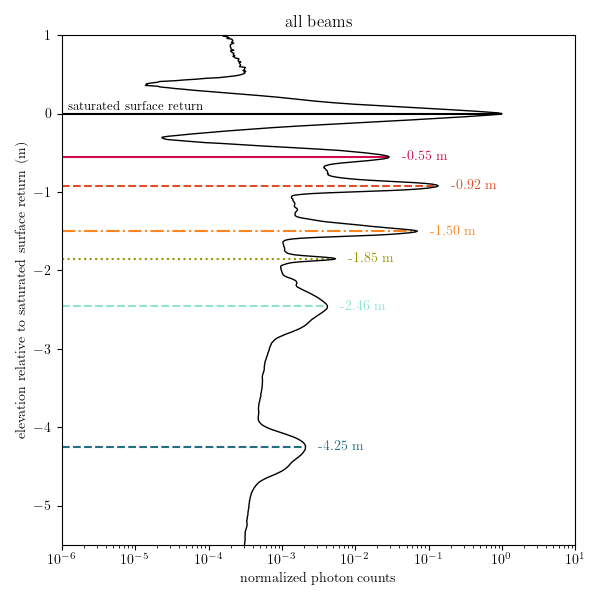

In [90]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

thresh_upper = 1.005
thresh_lower = -5.505

peak_target_elevs = [0.0, -0.55, -0.92, -1.50, -1.85, -2.46, -4.25]
widths_pk = [0.0, 0.3, 0.225, 0.225, 0.225, 0.35, 0.3]
cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']
lsty_pk = ['-', '-', '--', '-.', ':', '--', '--']

# for i, beam_select in enumerate(['all', 'strong', 'weak'] + list(np.arange(1,7))):
for i, beam_select in enumerate(['all']):

    fig, ax = plt.subplots(figsize=[6, 6], dpi=100)
    ylms = (thresh_lower, thresh_upper)
    xlim_ax = (1e-6,10)

    vals = df['smooth_%s'%beam_select]
    ax.plot(vals, df.elev_bins, 'k-', lw=1)
    for i in range(len(peak_target_elevs)):
        thish = peak_target_elevs[i]
        thispeak_height = vals.iloc[np.argmin(np.abs(df.elev_bins-thish))]
        ax.plot([xlim_ax[0], thispeak_height], [thish]*2, color=cols_pk[i], ls=lsty_pk[i], zorder=-1000,solid_capstyle='butt')
        if i == 0:
            ax.text(1.2*xlim_ax[0], thish, 'saturated surface return', color=cols_pk[i], ha='left', va='bottom', fontsize=9)
        else:
            ax.text(thispeak_height*1.5, thish, '%.2f m' % thish, color=cols_pk[i], weight='bold', va='center', fontsize=10)

    if type(beam_select) == str:
        tit = '%s beams' % beam_select
    else:
        tit = 'beam %i' % beam_select
    ax.set_title(tit)
    
    ax.set_xlabel('normalized photon counts')
    ax.set_ylabel('elevation relative to saturated surface return (m)')
    ax.set_xlim(xlim_ax)
    ax.set_ylim(ylms)
    ax.set_xscale('log')
    
    fig.tight_layout()
    
    plt.savefig('plots/saturation_counts_beams_%s.jpg' % beam_select, dpi=600)

In [25]:
for i, beam_select in enumerate(['all', 'strong', 'weak'] + list(np.arange(1,7))):
    print(type(beam_select) == str)

True
True
True
False
False
False
False
False
False


In [67]:
thresh_upper = 1.005
thresh_lower = -5.505

peak_target_elevs = [0.0, -0.56, -0.93, -1.47, -1.85, -2.44, -4.25]
widths_pk = [0.0, 0.3, 0.225, 0.225, 0.225, 0.35, 0.3]
cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']
lsty_pk = ['-', '-', '--', '-.', ':', '--', '--']

def make_saturation_plot(dfs, beam_select='all', ax=None):
    if type(beam_select) == np.int64:
        dfs = dfs[dfs_all.beam_number == beam_select]
    elif 'gt' in beam_select:
        dfs = dfs[dfs_all.gtx == beam_select]
    elif beam_select == 'all':
        dfs = dfs
    else:
        dfs = dfs[dfs_all.beam_strength == beam_select]
    n_lakes = len(np.unique(dfs.lake_nr))
    print('There are %i lakes for the following beam selection: "%s"' % (n_lakes, beam_select))

    df_issat = dfs[dfs.is_saturated]

    bin_h = 0.01
    smooth_h_top = 0.05
    smooth_h_middle = 0.1
    smooth_h_bottom = 0.2
    switch1 = -1.2
    switch2 = -2.1
    bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
    mids = bins[:-1] + 0.5 * bin_h
    smooth_top = int(np.round(smooth_h_top/bin_h))
    smooth_middle = int(np.round(smooth_h_middle/bin_h))
    smooth_bottom = int(np.round(smooth_h_bottom/bin_h))
    histweights = np.array(dfs_all.ratio_saturation).astype(np.float64)
    hist_h = np.histogram(np.array(dfs_all.h_relative_to_saturated_peak).astype(np.float64), bins=bins, weights=histweights)
    hist_h_smooth_top = np.array(pd.Series(hist_h[0]).rolling(smooth_top,center=True,min_periods=1).mean())
    hist_h_smooth_middle = np.array(pd.Series(hist_h[0]).rolling(smooth_middle,center=True,min_periods=1).mean())
    hist_h_smooth_bottom = np.array(pd.Series(hist_h[0]).rolling(smooth_bottom,center=True,min_periods=1).mean())
    seg1 = hist_h_smooth_bottom[mids<=switch2]
    seg2 = hist_h_smooth_middle[(mids>switch2) & (mids<=switch1)]
    seg3 = hist_h_smooth_top[mids>switch1]
    hist_h_smooth = np.concatenate((seg1, seg2, seg3))
    hist_h_full = hist_h[0] / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    
    if not ax:
        fig, ax = plt.subplots(figsize=[6, 6], dpi=100)
    ylms = (thresh_lower, thresh_upper)
    xlim_ax = (1e-5,10)
    
    style = 'k:' if beam_select == 'weak' else 'k-'
    ax.plot(hist_h_smooth, mids, style, lw=1)
    ax.scatter(hist_h_full, mids, s=1, c='k', alpha=0.1)
    for i in range(len(peak_target_elevs)):
        thish = peak_target_elevs[i]
        thispeak_height = hist_h_smooth[np.argmin(np.abs(mids-thish))]
        ax.plot([xlim_ax[0], thispeak_height], [thish]*2, color=cols_pk[i], ls=lsty_pk[i], zorder=-1000)
        if i == 0:
            ax.text(1.1*xlim_ax[0], thish, 'saturated surface return', color=cols_pk[i], ha='left', va='bottom', fontsize=9)
        else:
            ax.text(thispeak_height, thish, r'\ \ \ \  %.2f m' % thish, color=cols_pk[i], weight='bold', va='center', fontsize=10)
    
    ax.set_xlabel('normalized photon counts')
    ax.set_ylabel('elevation relative to saturated surface return')
    ax.set_xlim(xlim_ax)
    ax.set_ylim(ylms)
    ax.set_xscale('log')
    return mids, hist_h_full, hist_h_smooth
    

There are 1001 lakes for the following beam selection: "all"


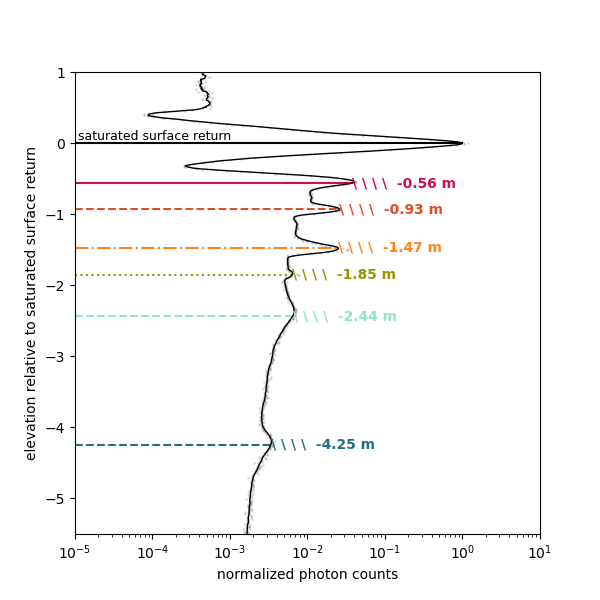

In [68]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

for i, beam_select in enumerate(['all', 'strong', 'weak'] + list(np.arange(1,7))):
# for i, beam_select in enumerate(['all', 'strong']):
    mids, hist_full, hist_smooth = make_saturation_plot(dfs_all, beam_select=beam_select)
    if i == 0:
        df = pd.DataFrame({'elev_bins': mids})
    df['counts_%s'%beam_select] = hist_full
    df['smooth_%s'%beam_select] = hist_smooth
    
df.to_csv('data/saturation_counts_methodsdata.csv', index=False)
df

In [47]:
hist_full

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [2]:
dfs_all = pd.read_pickle('afterpulse_dfs_all.pkl')

Text(0.5, 0, '98th percentile of pulse sensor saturation')

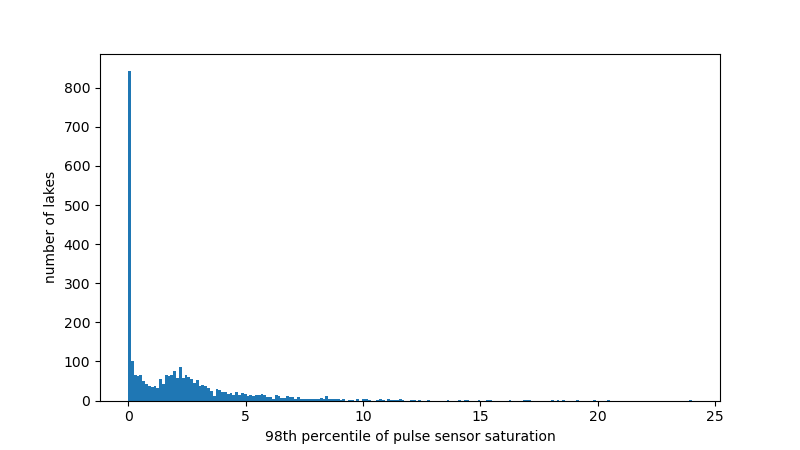

In [3]:
maxsats = dfs_all.groupby('lake_nr')['ratio_saturation'].apply(lambda x: np.percentile(x, 98))
fig, ax = plt.subplots(figsize=[8, 4.5], dpi=100)
ax.hist(maxsats, bins=200);
ax.set_ylabel('number of lakes')
ax.set_xlabel('98th percentile of pulse sensor saturation')

In [4]:
thresh_upper = 1.005
thresh_lower = -5.505

peak_target_elevs = [0.0, -0.56, -0.93, -1.47, -1.85, -2.44, -4.25]
widths_pk = [0.0, 0.3, 0.225, 0.225, 0.225, 0.35, 0.3]
cols_pk = ['black','#CD104D', '#E14D2A', '#FD841F', '#999400', '#8FE3CF', '#256D85']
lsty_pk = ['-', '-', '--', '-.', ':', '--', '--']

def make_saturation_plot(dfs, beam_select='all', ax=None):
    if type(beam_select) == np.int64:
        dfs = dfs[dfs_all.beam_number == beam_select]
    elif 'gt' in beam_select:
        dfs = dfs[dfs_all.gtx == beam_select]
    elif beam_select == 'all':
        dfs = dfs
    else:
        dfs = dfs[dfs_all.beam_strength == beam_select]
    n_lakes = len(np.unique(dfs.lake_nr))
    print('There are %i lakes for the following beam selection: "%s"' % (n_lakes, beam_select))

    df_issat = dfs[dfs.is_saturated]

    bin_h = 0.01
    smooth_h_top = 0.05
    smooth_h_middle = 0.1
    smooth_h_bottom = 0.2
    switch1 = -1.2
    switch2 = -2.1
    bins = np.arange(start=thresh_lower, stop=thresh_upper, step=bin_h)
    mids = bins[:-1] + 0.5 * bin_h
    smooth_top = int(np.round(smooth_h_top/bin_h))
    smooth_middle = int(np.round(smooth_h_middle/bin_h))
    smooth_bottom = int(np.round(smooth_h_bottom/bin_h))
    histweights = df_issat.ratio_saturation
    hist_h = np.histogram(df_issat.h_relative_to_saturated_peak, bins=bins, weights=histweights)
    hist_h_smooth_top = np.array(pd.Series(hist_h[0]).rolling(smooth_top,center=True,min_periods=1).mean())
    hist_h_smooth_middle = np.array(pd.Series(hist_h[0]).rolling(smooth_middle,center=True,min_periods=1).mean())
    hist_h_smooth_bottom = np.array(pd.Series(hist_h[0]).rolling(smooth_bottom,center=True,min_periods=1).mean())
    seg1 = hist_h_smooth_bottom[mids<=switch2]
    seg2 = hist_h_smooth_middle[(mids>switch2) & (mids<=switch1)]
    seg3 = hist_h_smooth_top[mids>switch1]
    hist_h_smooth = np.concatenate((seg1, seg2, seg3))
    hist_h_full = hist_h[0] / hist_h_smooth.max()
    hist_h_smooth /= hist_h_smooth.max()
    
    if not ax:
        fig, ax = plt.subplots(figsize=[6, 6], dpi=100)
    ylms = (thresh_lower, thresh_upper)
    xlim_ax = (1e-5,10)
    
    style = 'k:' if beam_select == 'weak' else 'k-'
    ax.plot(hist_h_smooth, mids, style, lw=1)
    ax.scatter(hist_h_full, mids, s=1, c='k', alpha=0.1)
    for i in range(len(peak_target_elevs)):
        thish = peak_target_elevs[i]
        thispeak_height = hist_h_smooth[np.argmin(np.abs(mids-thish))]
        ax.plot([xlim_ax[0], thispeak_height], [thish]*2, color=cols_pk[i], ls=lsty_pk[i], zorder=-1000)
        if i == 0:
            ax.text(1.1*xlim_ax[0], thish, 'saturated surface return', color=cols_pk[i], ha='left', va='bottom', fontsize=9)
        else:
            ax.text(thispeak_height, thish, r'\ \ \ \  %.2f m' % thish, color=cols_pk[i], weight='bold', va='center', fontsize=10)
    
    ax.set_xlabel('normalized photon counts')
    ax.set_ylabel('elevation relative to saturated surface return')
    ax.set_xlim(xlim_ax)
    ax.set_ylim(ylms)
    ax.set_xscale('log')
    return mids, hist_h_full, hist_h_smooth
    

There are 2940 lakes for the following beam selection: "all"
There are 1770 lakes for the following beam selection: "strong"
There are 1170 lakes for the following beam selection: "weak"
There are 618 lakes for the following beam selection: "1"
There are 402 lakes for the following beam selection: "2"
There are 575 lakes for the following beam selection: "3"
There are 378 lakes for the following beam selection: "4"
There are 577 lakes for the following beam selection: "5"
There are 390 lakes for the following beam selection: "6"


,elev_bins,counts_all,smooth_all,counts_strong,smooth_strong,counts_weak,smooth_weak,counts_1,smooth_1,counts_2,smooth_2,counts_3,smooth_3,counts_4,smooth_4,counts_5,smooth_5,counts_6,smooth_6
0,-5.50,0.001116,0.001190,0.001201,0.001222,0.001003,0.001146,0.001744,0.001852,0.001595,0.001607,0.000740,0.000738,0.000646,0.000804,0.002068,0.002063,0.001487,0.001721
1,-5.49,0.001175,0.001191,0.001155,0.001233,0.001202,0.001134,0.001956,0.001861,0.001550,0.001595,0.000606,0.000755,0.000886,0.000806,0.002001,0.002052,0.001812,0.001667
2,-5.48,0.001203,0.001188,0.001230,0.001236,0.001166,0.001123,0.002045,0.001861,0.001965,0.001627,0.000615,0.000751,0.000744,0.000775,0.002276,0.002083,0.001637,0.001671
3,-5.47,0.001224,0.001192,0.001274,0.001232,0.001156,0.001137,0.001801,0.001871,0.001399,0.001654,0.000805,0.000751,0.000800,0.000782,0.002189,0.002049,0.001994,0.001694
4,-5.46,0.001178,0.001191,0.001201,0.001226,0.001148,0.001145,0.002131,0.001852,0.001812,0.001674,0.000739,0.000751,0.000677,0.000787,0.001594,0.002038,0.001907,0.001699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,0.95,0.000308,0.000358,0.000198,0.000233,0.000457,0.000527,0.000213,0.000245,0.000290,0.000511,0.000189,0.000231,0.000335,0.000461,0.000207,0.000224,0.001003,0.000742
646,0.96,0.000325,0.000359,0.000191,0.000231,0.000506,0.000532,0.000272,0.000243,0.000465,0.000486,0.000165,0.000218,0.000547,0.000468,0.000178,0.000261,0.000424,0.000776
647,0.97,0.000369,0.000334,0.000237,0.000206,0.000547,0.000508,0.000260,0.000250,0.000551,0.000472,0.000183,0.000176,0.000472,0.000464,0.000390,0.000252,0.000772,0.000681
648,0.98,0.000351,0.000341,0.000215,0.000208,0.000535,0.000521,0.000194,0.000259,0.000580,0.000517,0.000188,0.000173,0.000482,0.000496,0.000331,0.000263,0.000653,0.000601


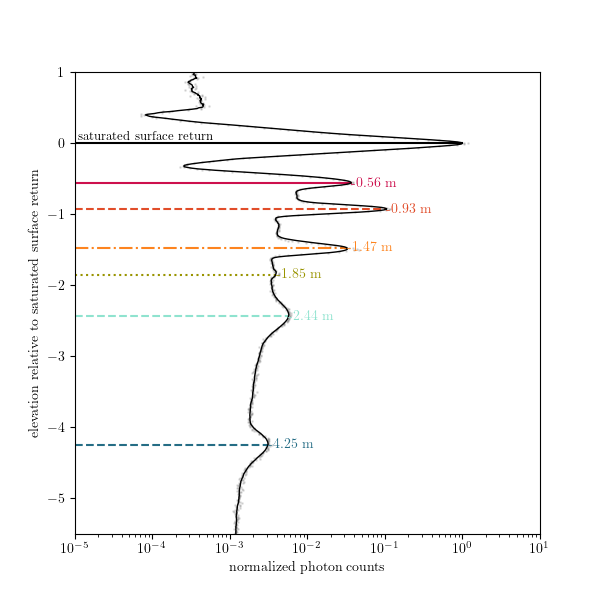

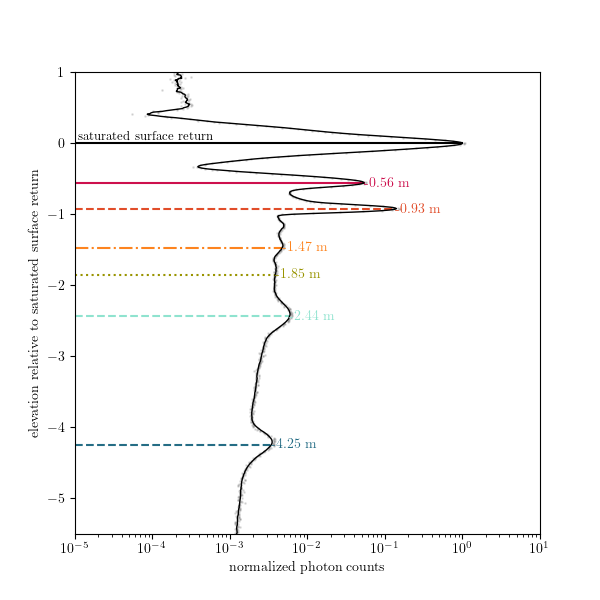

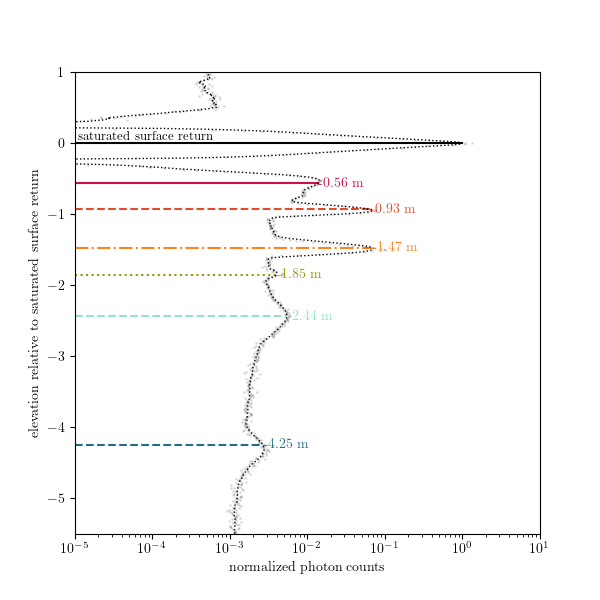

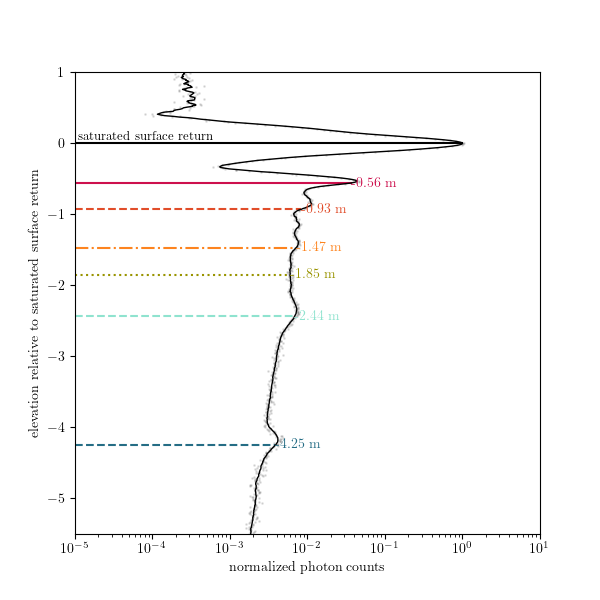

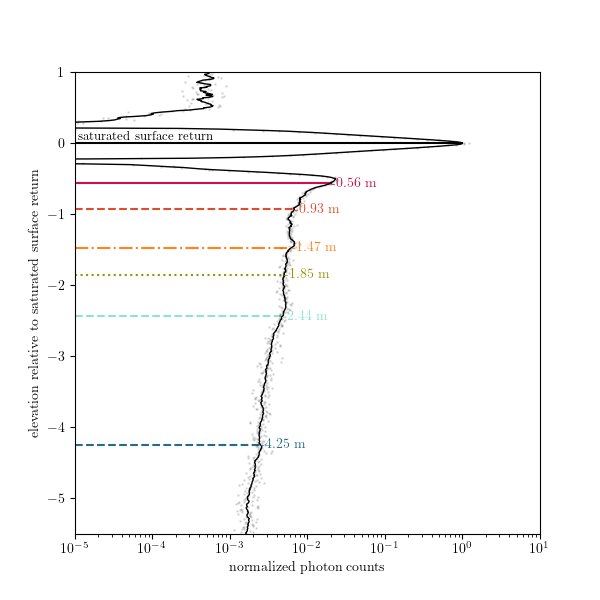

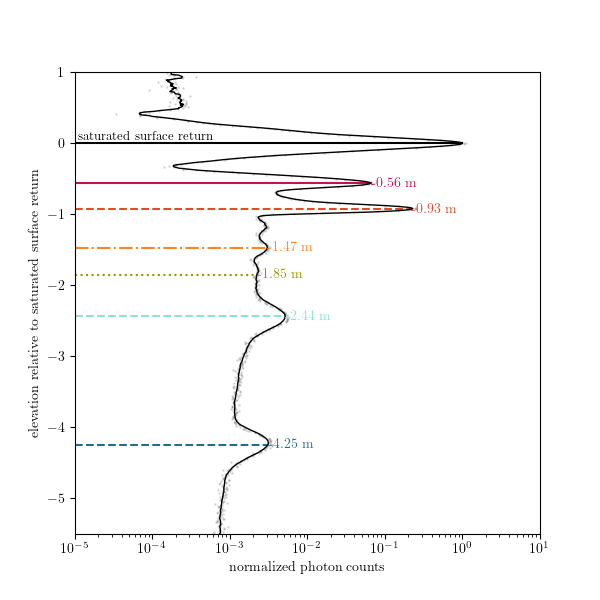

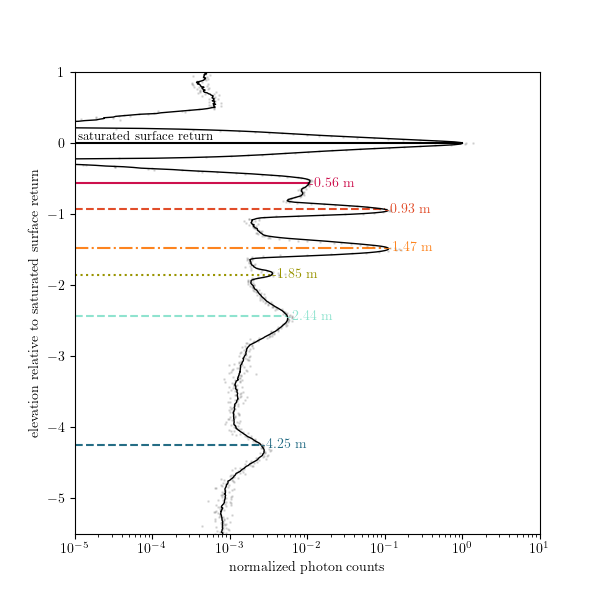

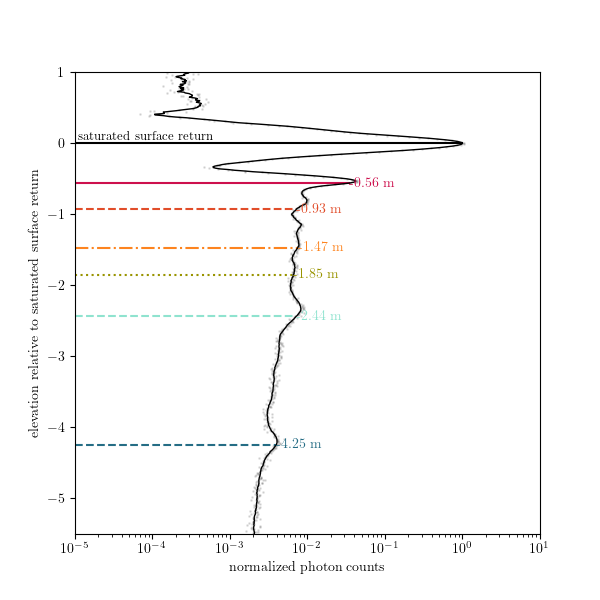

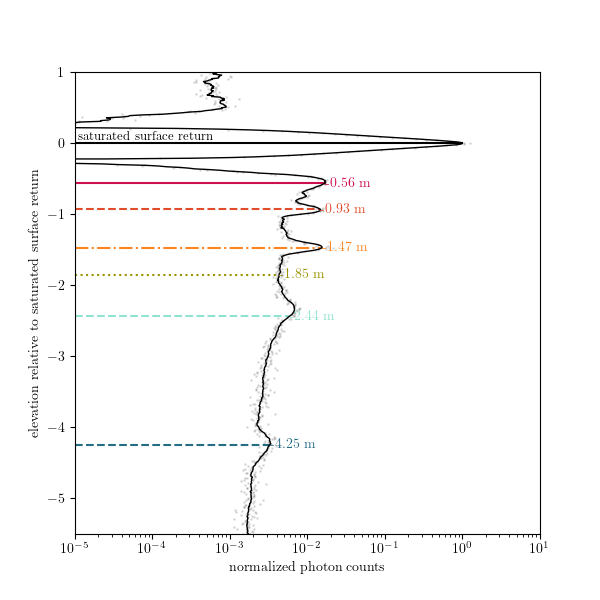

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Optima"
})

for i, beam_select in enumerate(['all', 'strong', 'weak'] + list(np.arange(1,7))):
# for i, beam_select in enumerate(['all', 'strong']):
    mids, hist_full, hist_smooth = make_saturation_plot(dfs_all, beam_select=beam_select)
    if i == 0:
        df = pd.DataFrame({'elev_bins': mids})
    df['counts_%s'%beam_select] = hist_full
    df['smooth_%s'%beam_select] = hist_smooth
    
df.to_csv('data/saturation_counts.csv', index=False)
df